# Data Preprocessing

In [9]:
#load CompositeEmbeddings.csv into a dataframe
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
df = pd.read_csv('CompositeEmbeddings.csv')

# define a function to convert string to list
def str_to_list(s):
    s = s.strip('[]')
    s_list = s.split()
    return [np.float64(i) for i in s_list]

df['sbert_embedding'] = df['sbert_embedding'].apply(lambda x: ast.literal_eval(x))
df['mpnet_embedding'] = df['mpnet_embedding'].apply(str_to_list)
df.rename(columns={'sbert_embedding':'train_y', 'mpnet_embedding':'train_x'}, inplace=True)

#get train_x and train_y as numpy arrays
train_x = np.array(df['train_x'].tolist())
train_y = np.array(df['train_y'].tolist())

# split your data into training and test sets
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

#x: sbert_embedding (768 dim)
#y: mpnet_embedding (384 dim)

# Neural Net

Epoch 1/50
125/125 [==============================] - 1s 8ms/step - loss: -0.3381 - val_loss: -0.5327
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: -0.5157 - val_loss: -0.5960
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: -0.5656 - val_loss: -0.6204
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: -0.5943 - val_loss: -0.6382
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: -0.6131 - val_loss: -0.6490
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: -0.6275 - val_loss: -0.6572
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: -0.6391 - val_loss: -0.6626
Epoch 8/50
125/125 [==============================] - 1s 8ms/step - loss: -0.6469 - val_loss: -0.6667
Epoch 9/50
125/125 [==============================] - 1s 7ms/step - loss: -0.6557 - val_loss: -0.6723
Epoch 10/50
125/125 [==============================] - 1s 7ms/step - loss: -0.6630

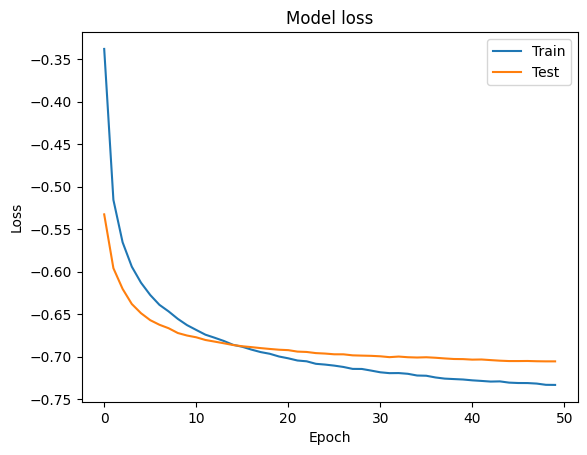

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

# create an instance of the Adam optimizer with a custom learning rate
# opt = Adam(learning_rate=0.001)  # change this to your desired learning rate

def cosine_similarity_loss(y_true, y_pred):
    y_true = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred = tf.nn.l2_normalize(y_pred, axis=-1)
    return -tf.reduce_mean(tf.reduce_sum(y_true * y_pred, axis=-1))

# Initialize the constructor
model = Sequential()


# Add an first hidden layer 
model.add(Dense(1024, activation='relu', input_shape=(768,), kernel_regularizer=l2(0.00)))

# Add a dropout layer for regularization
model.add(Dropout(0.5))

# Add a second hidden layer
model.add(Dense(1023, activation='relu', kernel_regularizer=l2(0.00)))

# Add a dropout layer for regularization
model.add(Dropout(0.5))


# Add an output layer 
model.add(Dense(384, activation='linear'))

# compile model
model.compile(loss=cosine_similarity_loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))

# add early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# fit the model to the training data
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50, batch_size=32, callbacks=[es])

# plot the training loss
plt.plot(history.history['loss'])
# plot the validation loss
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [11]:
import numpy as np

def avg_cosine_similarity(vectors):
    similarities = []
    for i in range(len(vectors) - 1):
        for j in range(i+1, len(vectors)):
            similarity = np.dot(vectors[i], vectors[j]) / (np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[j]))
            similarities.append(similarity)
    return np.mean(similarities)

avg_cos_sim = avg_cosine_similarity(train_y)
print("Average Cosine Similarity: ", avg_cos_sim)

Average Cosine Similarity:  0.0421793743404727


In [13]:
from sentence_transformers import SentenceTransformer
mpnet_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

encoding_target = ["hello, how are you doing today?"]
mpnet_encoded_data = [mpnet_model.encode(x) for x in encoding_target]


sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
sbert_encoded_data = [sbert_model.encode(x) for x in encoding_target]

#input: mpnet encoded.
#output: sbert encoded.

#forward pass (mpnet) -> pseudo-sbert
#cosine similarity between sbert and pseudo sbert

print(len(mpnet_encoded_data[0]))
print(len(sbert_encoded_data[0]))

768
384


In [17]:

# predictions = model.predict()
# model.summary()

AttributeError: 'list' object has no attribute 'shape'